https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv("./creditcard.csv")
print('dataset shape:', card_df.shape)
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


타겟 : Class 속성 0 정상, 1 사기 거래
클래스의 분포 확인 > 0.1%
Time : second, 각 거래와 이전 거래 사이의 경과 시간
Amount : 거래 금액



# 언더 샘플링, 오버 샘플링
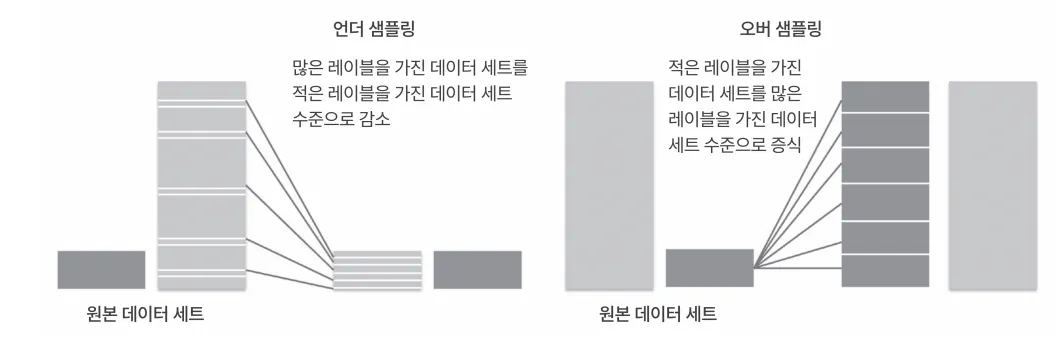

## 전처리 함수 get_preprocessed_df()

In [5]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)

    
    return df_copy

## get_train_test_dataset()

In [6]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

## 분포 확인


In [7]:
print(f'학습데이터의 사기거래 비율은 : {y_train.value_counts()/y_train.shape[0]*100}')
print(f'테스트데이터의 사기거래 비율은 : {y_test.value_counts()/y_test.shape[0]*100}')

학습데이터의 사기거래 비율은 : 0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터의 사기거래 비율은 : 0    99.826785
1     0.173215
Name: Class, dtype: float64


## 평가함수 get_clf_eval()

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## LR

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9541


## LGBM 모델 생성

## get_model_train_eval()

In [9]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


# 피처 특성을 파악, 전처리추가

1. Amount 피처

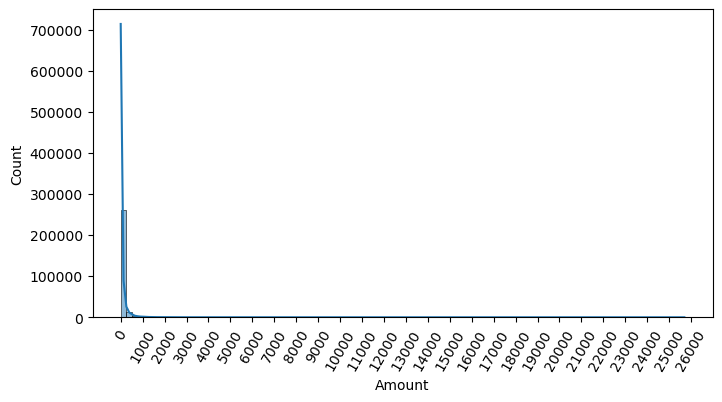

In [12]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

## get_preprocessed_df() 스케일러 추가

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_scaled', amount_n)

    
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

## logistic regression 모델 생성

In [2]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [12]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9541


### RF, XGBoost, LGBM 모델의 비교

In [13]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train,X_test, y_train, y_test )

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


1차 LGBM 실행 결과 오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

2차 
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

## get_preprocessed_df() Amount value 의 log 처리

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)

    
    return df_copy

In [15]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

### LR

In [16]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

오차 행렬
[[85272    23]
 [   51    97]]
정확도: 0.9991, 정밀도: 0.8083, 재현율: 0.6554,    F1: 0.7239, AUC:0.9342


* standardscaler

오차 행렬
[[85282    13]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8762, 재현율: 0.6216,    F1: 0.7273, AUC:0.9648

### lgbm

In [17]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


1차 LGBM 실행 결과 오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

2차 
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

3차
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796

## 이상치 탐색
상관관계 - target, Class와의 음의상관관계 v14, v17

<AxesSubplot:>

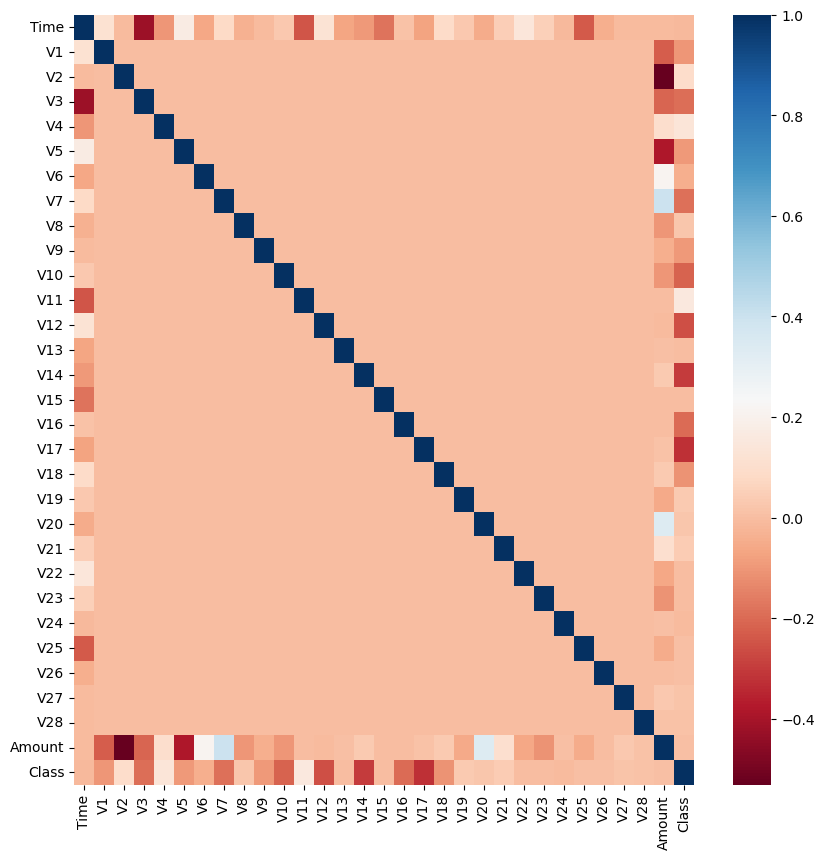

In [22]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

### get_outlier()

In [18]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출
    fraud = df[df['Class']==1][column]

    # 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight #lower
    highest_val = quantile_75 + iqr_weight #upper
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 해당 이상치 데이터의 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [19]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
outlier_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

### get_preprocessed_df()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_scaled', amount_n)

    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

### lr 모델 평가

In [21]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

오차 행렬
[[85280    15]
 [   55    91]]
정확도: 0.9992, 정밀도: 0.8585, 재현율: 0.6233,    F1: 0.7222, AUC:0.9564


오차 행렬
[[85272    23]
 [   51    97]]
정확도: 0.9991, 정밀도: 0.8083, 재현율: 0.6554,    F1: 0.7239, AUC:0.9342

### LGBM 테스트

In [22]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761


1차 LGBM 실행 결과 오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

2차 
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

3차
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796

4차
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761

# 속성 V17 처리

# SMOTE - 오버샘플링을 할 때 알고리즘

sklearn.imblearn.over_sample.SMOTE

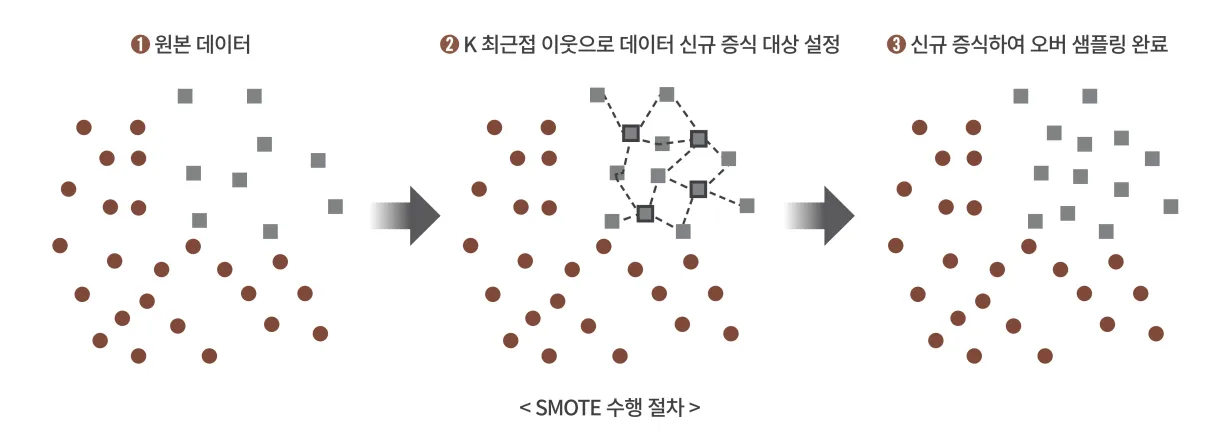

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train )

print(f'X_train : {X_train.shape} y_train: {y_train.shape}')
print(f'X_train_over : {X_train_over.shape} y_train_over: {y_train_over.shape}')

X_train : (199362, 30) y_train: (199362,)
X_train_over : (398040, 30) y_train_over: (398040,)


In [26]:
print(f' y_train_over.value_counts(): ')
print(f'{ pd.Series(y_train_over).value_counts()}')

 y_train_over.value_counts(): 
0    199020
1    199020
Name: Class, dtype: int64


## smote data - LR

In [28]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test )

오차 행렬
[[83580  1715]
 [   12   134]]
정확도: 0.9798, 정밀도: 0.0725, 재현율: 0.9178,    F1: 0.1343, AUC:0.9746


오차 행렬
[[85280    15]
 [   55    91]]
정확도: 0.9992, 정밀도: 0.8585, 재현율: 0.6233,    F1: 0.7222, AUC:0.9564

## smote data - Lgbm

In [29]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85284    11]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.8288,    F1: 0.8705, AUC:0.9857


1차 LGBM 실행 결과 오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

2차 
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

3차
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796

4차
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761

# 정밀도 재현율의 관계 - 임계치 체크


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

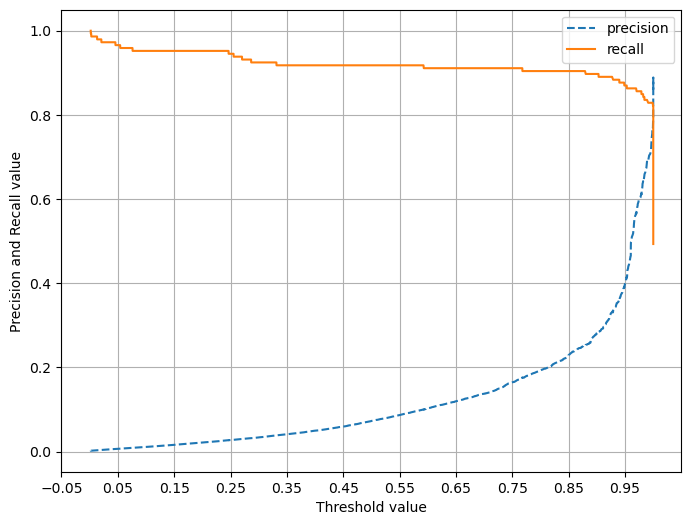

In [32]:
#LR의 smote이전 모델 성능
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
#LR의 smote이후 모델 성능
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
#LGBM